In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_ml as pdml

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

%matplotlib inline
pd.options.display.max_columns = None
pd.options.display.max_rows = None
plt.rcParams['figure.figsize'] = (10.0, 8.0)

In [2]:
# Read the datasets and retain only the records with loan_statuses Fully Paid, Charged Off, Default, Late (31-120 days)

# Define a function for string % convertion to a float ratio
def p2f(x):
    perc = None
    if (x != None) :
        if (type(x) is str) :
            x = x.strip('%')
        perc = float(x)/100
    return perc

loans_2014 = pd.read_csv('./LoanStats2014.csv', skiprows=1, skipfooter=2, parse_dates = [15, 26, 45,47, 48], 
                        infer_datetime_format = True, engine = 'python', converters = {'int_rate' : p2f, 'revol_util' : p2f})
loans_2014 = loans_2014[loans_2014.loan_status.isin(['Fully Paid', 'Charged Off', 'Default', 'Late (31-120 days)'])]


In [3]:
loans_1213 = pd.read_csv('./LoanStats2012to2013.csv', skiprows=1, skipfooter=2, parse_dates = [15, 26, 45,47, 48], 
                        infer_datetime_format = True, engine = 'python', converters = {'int_rate' : p2f, 'revol_util' : p2f})
loans_1213 = loans_1213[loans_1213.loan_status.isin(['Fully Paid', 'Charged Off', 'Default', 'Late (31-120 days)'])]


In [4]:
loans_2015 = pd.read_csv('./LoanStats2015.csv', skiprows=1, skipfooter=2, parse_dates = [15, 26, 45,47, 48], 
                        infer_datetime_format = True, engine = 'python', converters = {'int_rate' : p2f, 'revol_util' : p2f})
loans_2015 = loans_2015[(loans_2015.loan_status.isin(['Fully Paid', 'Charged Off', 'Default', 'Late (31-120 days)'])) & (loans_2015.application_type == 'INDIVIDUAL')] 

In [5]:
#Merging the datasets
frames = [loans_1213,loans_2014, loans_2015]
loan_data = pd.concat(frames, axis = 0)

In [6]:
#Removing the attribute columns that have all null values. Only the attributes listed in the DataDictionary will remain.
# Since 2012-2013 dataset is having the minimal features, using that as the reference for column list
loans_1213.dropna(axis = 1, how = 'all', inplace= True)
loan_data = loan_data[loans_1213.columns]

In [7]:
#calculating roi
loan_data['roi_inv'] = (loan_data.total_pymnt_inv - loan_data.funded_amnt_inv) / loan_data.funded_amnt_inv


In [8]:
#Dropping textual and informational columns from the dataset
loan_data.drop(['emp_title', 'desc', 'title', 'addr_state', 'zip_code','application_type'  ], axis = 1, inplace = True)

#Removing some loan records which have nans for many critical features. (total credit limit, accounts past due etc)
loan_data.dropna(axis = 0, how = 'any', subset = ['tot_hi_cred_lim', 'tot_cur_bal', 'num_tl_120dpd_2m', 'revol_util',
                                             'bc_open_to_buy', 'bc_util', 'mths_since_recent_bc', 'pct_tl_nvr_dlq', 'num_rev_accts'], 
             inplace = True)
#Dropping loan repayment releated features 
loan_data.drop(['issue_d', 'next_pymnt_d','last_pymnt_d', 'collection_recovery_fee', 'last_pymnt_amnt','out_prncp', 
                'out_prncp_inv', 'recoveries', 'total_pymnt', 'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee', 
                'total_rec_prncp','last_credit_pull_d'], axis = 1, inplace = True)



In [9]:
#revol_util is being cast as object due to some unknown reason - forcing to float
loan_data['revol_util'] = loan_data['revol_util'].astype(np.float64)

In [10]:
#For plotting mo_sin_last_pymnt vs mo_sin_last_credit_pull

#loan_data['last_pymnt_d'] = loan_data['last_pymnt_d'].fillna(pd.to_datetime('2017-05-03'))
#loan_data['mo_sin_last_pymnt'] = ((datetime.strptime('2017-04-02', '%Y-%m-%d') - loan_data['last_pymnt_d']) / np.timedelta64(1, 'M')).astype(int)
#loan_data['last_credit_pull_d'] = loan_data['last_credit_pull_d'].fillna(pd.to_datetime('2017-05-03'))
#loan_data['mo_sin_last_credit_pull'] = ((datetime.strptime('2017-04-02', '%Y-%m-%d') - loan_data['last_credit_pull_d']) / np.timedelta64(1, 'M')).astype(int)
#ax = sns.boxplot(x = 'loan_status', y = 'mo_sin_last_credit_pull', data = loan_data  )
#sns.countplot(x = 'mo_sin_last_credit_pull', hue = 'loan_status', data=loan_data)

In [11]:
#For plotting mo_sin_last_pymnt vs mo_sin_last_credit_pull
#ax = sns.lmplot(x = 'mo_sin_last_pymnt', y = 'mo_sin_last_credit_pull', data = loan_data, hue = 'loan_status', x_estimator= np.mean, 
#           fit_reg=False, ci = 99.5)
#ax.set_xlabels('Months since the last payment')
#ax.set_ylabels('Months since the last credit report pulled by LC')
#ax.ax.set_xlim(0, 65)

In [12]:
#Transform date fields into appropriate duration units
from datetime import datetime
ref_datetime = datetime.strptime('2017-04-02', '%Y-%m-%d')

# Earliest credit line
loan_data['mo_sin_earliest_cr_line'] = ((ref_datetime - loan_data['earliest_cr_line']) / np.timedelta64(1, 'M')).astype(int)

loan_data.drop([ 'earliest_cr_line'], axis = 1, inplace = True)


In [13]:
# Imputing missing values

#mths_since_last_delinq
# this will be null when the applicant has no prior delinquencies. Imputing these to -1 to set these apart.
loan_data['mths_since_last_delinq'] = loan_data['mths_since_last_delinq'].fillna(-1)

#mths_since_last_record
# this will be null when the applicant has no public records. Imputing these to -1 to set these apart.
loan_data['mths_since_last_record'] = loan_data['mths_since_last_record'].fillna(-1)

#mths_since_last_major_derog
# this will be null when the applicant has no previous derogatory records. Imputing these to -1 to set these apart.
loan_data['mths_since_last_major_derog'] = loan_data['mths_since_last_major_derog'].fillna(-1)

#mo_sin_old_il_acct
# this will be null when the applicant has no bank installment accounts. Imputing these to -1 to set these apart.
loan_data['mo_sin_old_il_acct'] = loan_data['mo_sin_old_il_acct'].fillna(-1)

#mths_since_recent_bc_dlq
# this will be null when there's no previous bankcard delinquency. Imputing these to -1 to set these apart.
loan_data['mths_since_recent_bc_dlq'] = loan_data['mths_since_recent_bc_dlq'].fillna(-1)

#mths_since_recent_inq
# this will be null when there's no previous inquiries. Imputing these to -1 to set these apart.
loan_data['mths_since_recent_inq'] = loan_data['mths_since_recent_inq'].fillna(-1)

#mths_since_recent_revol_delinq
# this will be null when there's no previous revolving account delinquencies. Imputing these to -1 to set these apart.
loan_data['mths_since_recent_revol_delinq'] = loan_data['mths_since_recent_revol_delinq'].fillna(-1)


In [14]:
# Converting absolute dollar values as a fraction of the borrower's annual income.
loan_data['revol_bal_over_annual_inc'] = loan_data.revol_bal / loan_data.annual_inc
loan_data['tot_cur_bal_over_annual_inc'] = loan_data.tot_cur_bal / loan_data.annual_inc
loan_data['avg_cur_bal_over_annual_inc'] = loan_data.avg_cur_bal / loan_data.annual_inc
loan_data['bc_open_to_buy_over_annual_inc'] = loan_data.bc_open_to_buy / loan_data.annual_inc
loan_data['delinq_amnt_over_annual_inc'] = loan_data.delinq_amnt / loan_data.annual_inc
loan_data['total_bal_ex_mort_over_annual_inc'] = loan_data.total_bal_ex_mort / loan_data.annual_inc
loan_data['total_bc_limit_over_annual_inc'] = loan_data.total_bc_limit / loan_data.annual_inc
loan_data['total_il_high_credit_limit_over_annual_inc'] = loan_data.total_il_high_credit_limit / loan_data.annual_inc

loan_data.drop(['revol_bal', 'tot_cur_bal', 'avg_cur_bal', 'bc_open_to_buy', 'delinq_amnt','total_bal_ex_mort', 'total_bc_limit',
              'total_il_high_credit_limit'], axis=1, inplace = True)

In [15]:
#Converting Grade and sub_grade to numeric.
loan_data['grade_numeric'] = loan_data.grade.astype("category", categories=['G', 'F','E', 'D', 'C', 'B', 'A'], ordered=True)
loan_data['grade_numeric'] = loan_data.grade_numeric.cat.codes
loan_data['grade_numeric'] = loan_data.grade_numeric.map(int)

loan_data['sub_grade_numeric'] = loan_data.sub_grade.astype("category", 
                                                          categories=['G5', 'G4', 'G3', 'G2', 'G1',
                                                                     'F5', 'F4', 'F3', 'F2', 'F1',
                                                                     'E5', 'E4', 'E3', 'E2', 'E1',
                                                                     'D5', 'D4', 'D3', 'D2', 'D1',
                                                                     'C5', 'C4', 'C3', 'C2', 'C1',
                                                                     'B5', 'B4', 'B3', 'B2', 'B1',
                                                                     'A5', 'A4', 'A3', 'A2', 'A1'], ordered=True)
loan_data['sub_grade_numeric'] = loan_data.sub_grade_numeric.cat.codes
loan_data['sub_grade_numeric'] = loan_data.sub_grade_numeric.map(int)

#loan_data.drop(['grade', 'sub_grade'], axis=1, inplace = True)

In [16]:
#Cleaning Emp length
loan_data['emp_length_numeric'] = loan_data.emp_length.str.replace('+','')
loan_data['emp_length_numeric'] = loan_data.emp_length_numeric.str.replace('<','')
loan_data['emp_length_numeric'] = loan_data.emp_length_numeric.str.replace('years','')
loan_data['emp_length_numeric'] = loan_data.emp_length_numeric.str.replace('year','')
loan_data['emp_length_numeric'] = loan_data.emp_length_numeric.str.replace('n/a','-1')
loan_data['emp_length_numeric'] = loan_data.emp_length_numeric.map(int)

loan_data.drop(['emp_length'], axis=1, inplace = True)

In [17]:
# Convert categorical features to One Hot Encode format using Pandas getDummies
categorical_features = [ 'home_ownership', 'verification_status', 'pymnt_plan', 'purpose', 'initial_list_status', 'term']
loan_data = pd.get_dummies(columns = categorical_features, data= loan_data, )


In [18]:
# Classify the loans as 'Good' ,'Bad', 'Delinquent'

def classify_loan(row) :
    val = ''
    #if ((row.loan_status in ['Fully Paid', 'Current']) ) :
    if ((row.loan_status in ['Fully Paid']) ) :
        val = '0-Good'
    else :
        val = '1-Bad'
    return val

loan_data['loan_class'] = loan_data.apply(classify_loan, axis = 1)

In [19]:
pd.DataFrame(loan_data.groupby('loan_class').size())

,0
loan_class,
0-Good,328825
1-Bad,98931


In [20]:
# Identifying X values - Removing the label columns and transformed features
#X = loan_data.drop(['loan_status', 'loan_class', 'grade', 'sub_grade'], axis = 1)
X = loan_data.drop(['loan_status', 'loan_class',  'sub_grade'], axis = 1)

loan_data['loan_class'] = loan_data.loan_class.astype('category')
Y = loan_data.loan_class.cat.codes


In [21]:
#create ModelFrame object
loans_mf = pdml.ModelFrame(X, target = Y)


In [22]:
loans_mf.to_csv('prepared_loans.csv', index = False)

## Exploratory Data Analysis

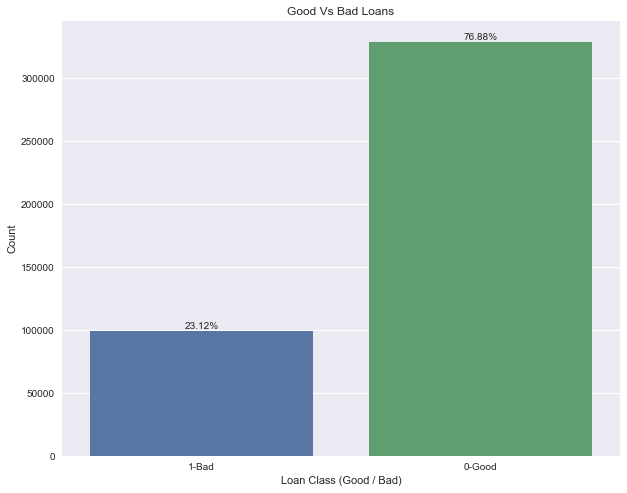

In [24]:
#Loans by Loan class
sns.set_context({"figure.figsize": (10, 8)})
ax = sns.countplot(x = 'loan_class', data = loan_data, order = ['1-Bad', '0-Good'])
ax.set_xlabel('Loan Class (Good / Bad)')
ax.set_ylabel('Count')
ax.set_title('Good Vs Bad Loans')

# Now make some labels
labels = ['23.12%', '76.88%']
rects = ax.patches
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
    
plt.savefig('Count_by_class.png')

In [25]:
#Loan Amount by Loan class
by_class = loan_data.groupby('loan_class').agg({'loan_amnt': 'sum'})
by_class =pd.DataFrame( by_class)
#by_class.index.name = None
#by_class.columns.name = None
total = np.sum(by_class)
by_class['perc'] = (by_class.div(total) * 100)
by_class['perc'] = by_class.perc.apply("{0:.2f}%".format)
by_class.reset_index(inplace = True)
by_class.rename(columns = { 'index' : 'loan_class'}, inplace = True)
by_class['loan_amnt'] = by_class.loan_amnt / 1000000000
by_class

,loan_class,loan_amnt,perc
0,0-Good,4.690903,75.35%
1,1-Bad,1.534366,24.65%


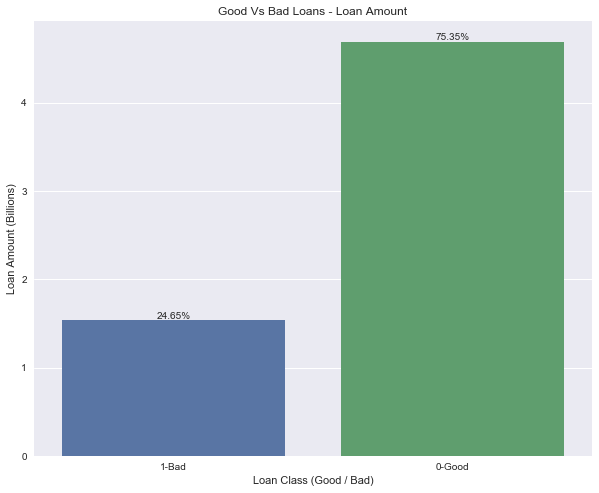

In [27]:
ax1 = sns.barplot(x = 'loan_class', y = 'loan_amnt', data = by_class, order = ['1-Bad', '0-Good'])
ax1.set_xlabel('Loan Class (Good / Bad)')
ax1.set_ylabel('Loan Amount (Billions)')
ax1.set_title('Good Vs Bad Loans - Loan Amount')

# Now make some labels
labels =['24.65%', '75.35%']
rects = ax1.patches
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width()/2, height , label, ha='center', va='bottom')
    
plt.savefig('Amnt_by_class.png')

In [28]:
#Loans by Grade
by_grade = loan_data.groupby(['grade', 'loan_class']).size()
#grade_total = loan_data.groupby('grade').size()
#by_grade_target_perc = by_grade.div(grade_total, level = 'grade').mul(100, level = 'grade')
#by_grade_target_perc = by_grade_target_perc.apply("{0:.2f}%".format)
by_grade = by_grade.unstack()
by_grade.index.name = None
by_grade.columns.name = None
by_grade.rename(columns = { '0-Good' : 'Good', '1-Bad': 'Bad'}, inplace = True)
by_grade['Total'] = by_grade.Good + by_grade.Bad
by_grade.loc['F + G'] = by_grade.loc['F'] + by_grade.loc['G']
by_grade.drop(['F', 'G'], inplace=True)
by_grade.reset_index(inplace = True)
by_grade.rename(columns = { 'index' : 'Grade'}, inplace = True)
by_grade

,Grade,Good,Bad,Total
0,A,60444,4768,65212
1,B,106253,18193,124446
2,C,87498,29477,116975
3,D,46492,23501,69993
4,E,20075,15102,35177
5,F + G,8063,7890,15953


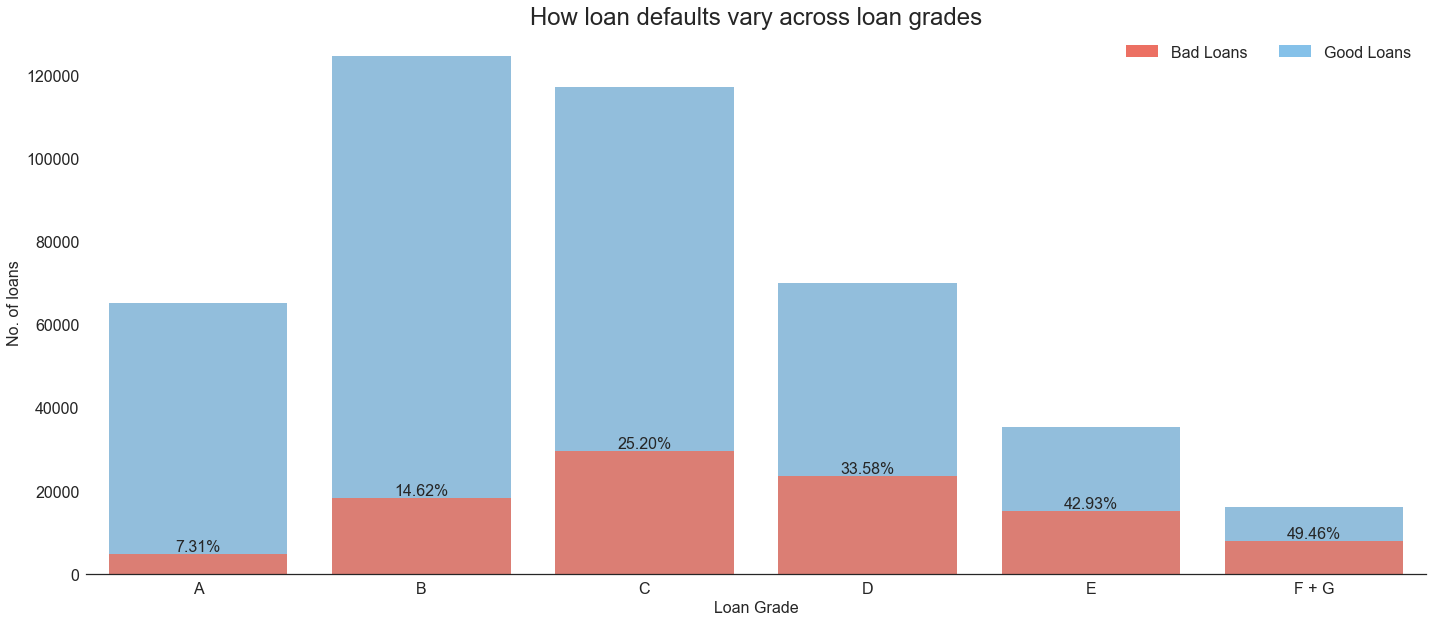

In [29]:
sns.set_style("white")
sns.set_context({"figure.figsize": (24, 10)})

bottom_plot = sns.barplot(x = 'Grade', y = 'Bad', data= by_grade, color = "#EC7063")
rects = bottom_plot.patches

#Plot 1 - background - "total" (top) series
top_plot = sns.barplot(x = 'Grade', y = 'Total', data= by_grade, color = "#85C1E9")


#Plot 2 - overlay - "bottom" series
bottom_plot = sns.barplot(x = 'Grade', y = 'Bad', data= by_grade, color = "#EC7063")


topbar = plt.Rectangle((0,0),1,1,fc="#85C1E9", edgecolor = 'none')
bottombar = plt.Rectangle((0,0),1,1,fc='#EC7063',  edgecolor = 'none')
l = plt.legend([bottombar, topbar], ['Bad Loans', 'Good Loans'], loc=1, ncol = 2, prop={'size':16})
l.draw_frame(False)

#Optional code - Make plot look nicer
sns.despine(left=True)
bottom_plot.set_ylabel("No. of loans")
bottom_plot.set_xlabel("Loan Grade")

bottom_plot.set_title('How loan defaults vary across loan grades', fontsize = 24)
#Set fonts to consistent 16pt size
for item in ([bottom_plot.xaxis.label, bottom_plot.yaxis.label] +
             bottom_plot.get_xticklabels() + bottom_plot.get_yticklabels()):
    item.set_fontsize(16)
    


# Now make some labels
labels = (by_grade.Bad / by_grade.Total *100).apply("{0:.2f}%".format)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    bottom_plot.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize = 16)
    
plt.savefig("By_Grade.png")

C:\Users\Anu\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
C:\Users\Anu\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


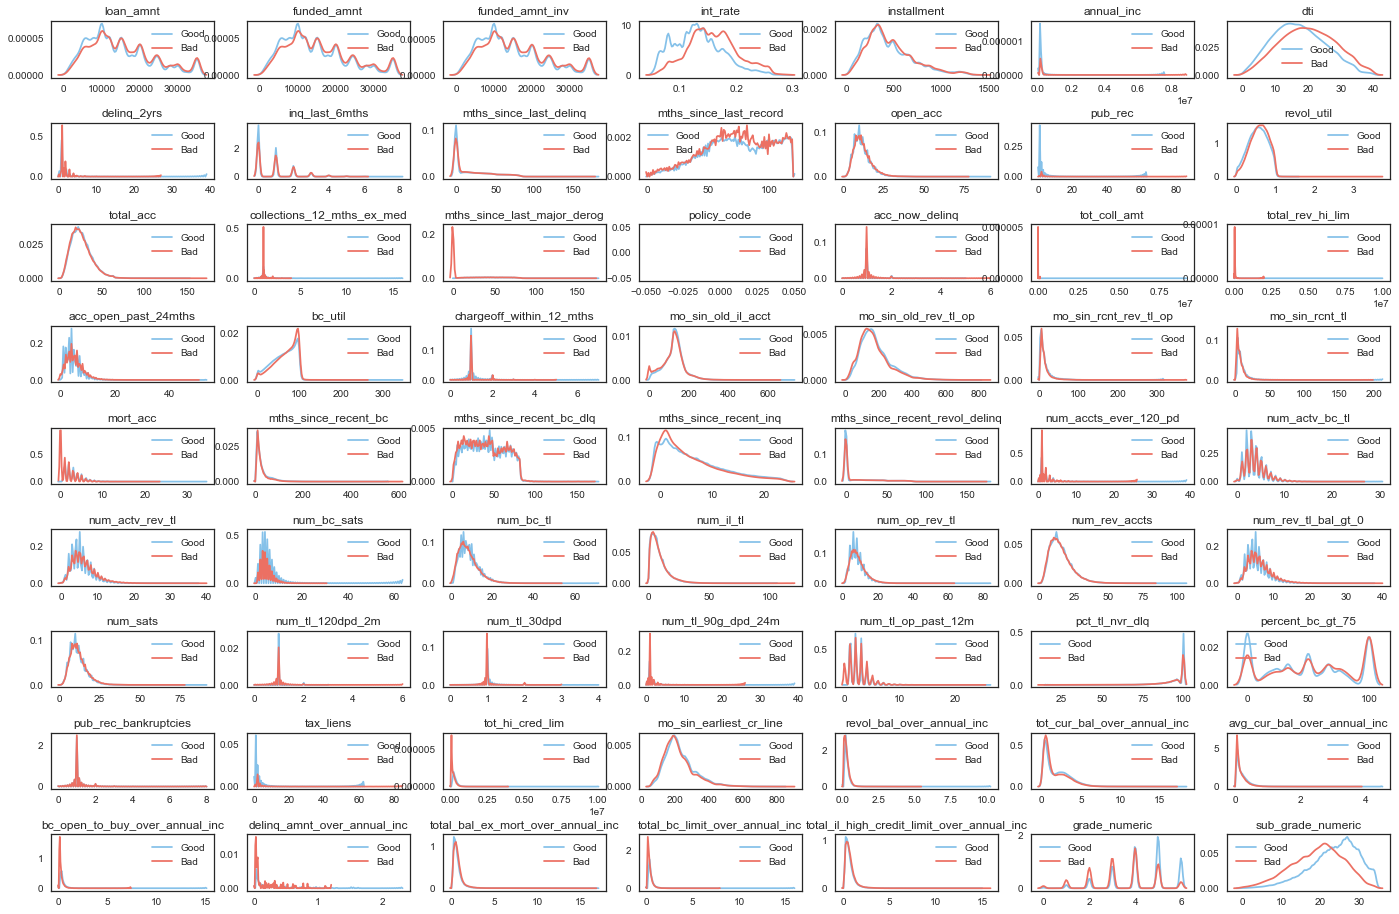

In [32]:
#Predictor variable trends
#Taking all predictor variables except the one-hot encoded categorical variables
cols_of_interest = X.drop(['roi_inv', 'grade'], axis = 1).columns[:64]
fig, axes = plt.subplots(9, 7)
plt.subplots_adjust(hspace = 0.8)
sns.set_context({"figure.figsize": (24, 16)})
good_loans = loan_data[loan_data.loan_class == '0-Good']
bad_loans = loan_data[loan_data.loan_class == '1-Bad']
for col, ax in zip(cols_of_interest, axes.reshape(-1)) :
    sns.kdeplot(good_loans[col], color ='#85C1E9', ax = ax, label = 'Good')
    sns.kdeplot(bad_loans[col], color ='#EC7063', ax = ax, label = 'Bad' )
    ax.set_title(col)
#plt.show()  
plt.savefig('Predictor_trends.png')